# Creating Enhanced LSTM Feature Set with Statistical Aggregations

## Introduction

This notebook explains the process of creating an enhanced feature set for LSTM-based PV power prediction. The key innovation in this approach is incorporating statistical aggregations from high-resolution (10-minute) data into an hourly feature set. 

### Why Statistical Aggregations Matter

Solar power generation is highly sensitive to short-term fluctuations in weather conditions:

- Passing clouds can cause rapid drops in irradiance
- Wind gusts affect panel temperature and efficiency
- Brief precipitation events can reduce power output

**Problem with Hourly Data**: Simple hourly averages smooth out these important variations, losing critical information.

**Solution**: Create statistical aggregations (mean, max, min, standard deviation) from 10-minute data to capture these sub-hourly dynamics while maintaining hourly timestamps for the LSTM model.

### Process Overview

1. Load 10-minute resolution data
2. Compute statistical aggregations (mean, max, min, std) for each hour
3. Merge these aggregated features with previously selected 1-hour features
4. Save the result as a new parquet file with hourly timestamps

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set plot styling
# plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Create directories for results
if not os.path.exists('results/feature_analysis'):
    os.makedirs('results/feature_analysis')

## 1. Data Loading and Exploration

We start by loading two datasets:
1. The high-resolution 10-minute interval data (`station_data_10min.parquet`)
2. The previously created hourly feature set (`lstm_features.parquet`)

The 10-minute data provides more granular information about weather conditions and power output, while the 1-hour data contains the previously selected features for LSTM modeling.

In [3]:
# Load datasets
print("Loading datasets...")
df_10min = pd.read_parquet('data/station_data_10min.parquet')
df_1h = pd.read_parquet('data/lstm_features.parquet')

print(f"10-minute data: {df_10min.shape} rows, {df_10min.shape[1]} columns")
print(f"1-hour data: {df_1h.shape} rows, {df_1h.shape[1]} columns")

Loading datasets...
10-minute data: (137882, 19) rows, 19 columns
1-hour data: (23117, 11) rows, 11 columns


Let's examine the 10-minute data to understand what's available:

In [7]:
# Display the columns and first few rows of the 10-minute data
print("\nColumns in 10-minute data:")
print(df_10min.columns.tolist())

# Show first few rows
print("\nSample of 10-minute data:")
df_10min.head(100)


Columns in 10-minute data:
['GlobalRadiation [W m-2]', 'Temperature [degree_Celsius]', 'WindSpeed [m s-1]', 'Precipitation [mm]', 'Pressure [hPa]', 'ClearSkyGHI', 'ClearSkyDNI', 'ClearSkyDHI', 'ClearSkyIndex', 'isNight', 'energy_wh', 'energy_interval', 'power_w', 'hour', 'day_of_year', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']

Sample of 10-minute data:


,GlobalRadiation [W m-2],Temperature [degree_Celsius],WindSpeed [m s-1],Precipitation [mm],Pressure [hPa],ClearSkyGHI,ClearSkyDNI,ClearSkyDHI,ClearSkyIndex,isNight,energy_wh,energy_interval,power_w,hour,day_of_year,hour_sin,hour_cos,day_sin,day_cos
time,,,,,,,,,,,,,,,,,,,
2022-07-14 20:00:00,0.0,22.4,1.7,0.0,952.1,0.000000,0.000000,0.000000,0.000000,1,0.000000,0.000,0.00000,20.000000,195,-8.660254e-01,0.500000,-0.211276,-0.977426
2022-07-14 20:10:00,0.0,22.3,2.0,0.0,952.1,0.000000,0.000000,0.000000,0.000000,1,0.000000,0.000,0.00000,20.166667,195,-8.433914e-01,0.537300,-0.211276,-0.977426
2022-07-14 20:20:00,0.0,22.2,1.8,0.0,952.2,0.000000,0.000000,0.000000,0.000000,1,0.000000,0.000,0.00000,20.333333,195,-8.191520e-01,0.573576,-0.211276,-0.977426
2022-07-14 20:30:00,0.0,21.9,1.9,0.0,952.2,0.000000,0.000000,0.000000,0.000000,1,0.000000,0.000,0.00000,20.500000,195,-7.933533e-01,0.608761,-0.211276,-0.977426
2022-07-14 20:40:00,0.0,21.7,1.3,0.0,952.3,0.000000,0.000000,0.000000,0.000000,1,0.000000,0.000,0.00000,20.666667,195,-7.660444e-01,0.642788,-0.211276,-0.977426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-15 11:50:00,198.0,24.2,1.2,0.0,954.8,718.663759,608.777924,335.345482,0.275511,0,161.880535,161.880,1942.56642,11.833333,196,4.361939e-02,-0.999048,-0.228058,-0.973648
2022-07-15 12:00:00,174.0,24.2,0.6,0.0,954.9,712.121659,606.332785,334.087468,0.244340,0,187.512440,187.515,2250.14928,12.000000,196,1.224647e-16,-1.000000,-0.228058,-0.973648
2022-07-15 12:10:00,491.0,24.8,1.1,0.0,954.8,704.298484,603.383917,332.571908,0.697148,0,194.874280,194.875,2338.49136,12.166667,196,-4.361939e-02,-0.999048,-0.228058,-0.973648


And the hourly feature set:

In [8]:
# Display the columns and first few rows of the hourly data
print("\nColumns in hourly data:")
print(df_1h.columns.tolist())

# Show first few rows
print("\nSample of hourly data:")
df_1h.head()


Columns in hourly data:
['GlobalRadiation [W m-2]', 'ClearSkyGHI', 'ClearSkyIndex', 'isNight', 'Temperature [degree_Celsius]', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'WindSpeed [m s-1]', 'power_w']

Sample of hourly data:


,GlobalRadiation [W m-2],ClearSkyGHI,ClearSkyIndex,isNight,Temperature [degree_Celsius],hour_sin,hour_cos,day_sin,day_cos,WindSpeed [m s-1],power_w
time,,,,,,,,,,,
2022-07-14 20:00:00,0.0,0.0,0.0,1.0,22.000000,-0.866025,0.500000,-0.211276,-0.977426,1.716667,0.0
2022-07-14 21:00:00,0.0,0.0,0.0,1.0,20.433333,-0.707107,0.707107,-0.211276,-0.977426,1.550000,0.0
2022-07-14 22:00:00,0.0,0.0,0.0,1.0,19.133333,-0.500000,0.866025,-0.211276,-0.977426,1.266667,0.0
2022-07-14 23:00:00,0.0,0.0,0.0,1.0,18.233333,-0.258819,0.965926,-0.211276,-0.977426,0.733333,0.0
2022-07-15 00:00:00,0.0,0.0,0.0,1.0,17.983333,0.000000,1.000000,-0.228058,-0.973648,1.833333,0.0


## 2. Visualizing Sub-hourly Variations

Before we compute statistical aggregations, let's visualize why they're important. We'll plot a single day of 10-minute data to see the variations that would be lost in hourly averages.

In [9]:
# Select a single day for visualization
# Choose a day with interesting variations (e.g., partially cloudy)
sample_date = '2023-06-15'  # You can adjust this to any date in your dataset
day_data = df_10min[sample_date]

# If the date doesn't exist, choose the first summer day in the dataset
if len(day_data) == 0:
    summer_days = df_10min[df_10min.index.month.isin([6, 7, 8])]
    if len(summer_days) > 0:
        first_summer_day = summer_days.index[0].date()
        day_data = df_10min[df_10min.index.date == first_summer_day]
    else:
        # Just take the first day with daylight
        day_data = df_10min[df_10min['GlobalRadiation [W m-2]'] > 100].iloc[:144]  # 24 hours of 10-min data

# Plot key variables for the day
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 10-minute data
day_data['GlobalRadiation [W m-2]'].plot(ax=axes[0, 0], title='Global Radiation (10-min intervals)')
axes[0, 0].set_ylabel('W/m²')

day_data['power_w'].plot(ax=axes[0, 1], title='Power Output (10-min intervals)', color='green')
axes[0, 1].set_ylabel('Watts')

# Calculate hourly averages for comparison
hourly_data = day_data.resample('1H').mean()

# Plot the hourly data alongside 10-min data for comparison
axes[1, 0].plot(day_data.index, day_data['GlobalRadiation [W m-2]'], 'b-', alpha=0.5, label='10-min data')
axes[1, 0].plot(hourly_data.index, hourly_data['GlobalRadiation [W m-2]'], 'ro-', label='Hourly average')
axes[1, 0].set_title('Global Radiation: 10-min vs Hourly')
axes[1, 0].set_ylabel('W/m²')
axes[1, 0].legend()

axes[1, 1].plot(day_data.index, day_data['power_w'], 'g-', alpha=0.5, label='10-min data')
axes[1, 1].plot(hourly_data.index, hourly_data['power_w'], 'ro-', label='Hourly average')
axes[1, 1].set_title('Power Output: 10-min vs Hourly')
axes[1, 1].set_ylabel('Watts')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Calculate the information loss
radiation_hourly_std = day_data.resample('1H')['GlobalRadiation [W m-2]'].std().mean()
power_hourly_std = day_data.resample('1H')['power_w'].std().mean()

print(f"Average standard deviation within each hour:")
print(f"  - Global Radiation: {radiation_hourly_std:.2f} W/m²")
print(f"  - Power Output: {power_hourly_std:.2f} W")

KeyError: '2023-06-15'

The plots above show how much information is lost when using only hourly averages. The standard deviation within each hour quantifies this variation. This is why we need statistical aggregations to capture:

1. **Maximum values** - Peak irradiance and power production potential
2. **Minimum values** - Worst-case scenarios within the hour
3. **Standard deviation** - Volatility and stability measures

## 3. Defining Features to Aggregate

Now we'll define which features to aggregate and which statistical functions to apply to each feature. We select features that:

1. Are physically relevant to PV power generation
2. Show significant sub-hourly variations
3. Represent different aspects of weather conditions

For each feature, we apply specific aggregation functions based on their physical meaning:

In [10]:
# Define features to aggregate
# These are key weather and irradiance features that can benefit from 
# capturing sub-hourly variations
features_to_aggregate = [
    'GlobalRadiation [W m-2]',     # Primary driver of PV generation
    'Temperature [degree_Celsius]', # Affects panel efficiency
    'WindSpeed [m s-1]',           # Affects panel cooling
    'ClearSkyIndex',               # Indicates cloud effects
    'Precipitation [mm]'           # Indicates rain events
]

# Define aggregation functions for each feature
aggregation_dict = {
    'GlobalRadiation [W m-2]': ['mean', 'max', 'min', 'std'],  # All statistics relevant for radiation
    'Temperature [degree_Celsius]': ['mean', 'max', 'min', 'std'],  # Temperature extremes affect efficiency
    'WindSpeed [m s-1]': ['mean', 'max', 'std'],  # Wind peaks important for cooling
    'ClearSkyIndex': ['mean', 'min', 'std'],  # Min captures worst cloud cover
    'Precipitation [mm]': ['sum', 'max']  # Sum captures total rainfall, max captures intensity
}

# Display the aggregation strategy
print("Aggregation strategy for each feature:")
for feature, aggs in aggregation_dict.items():
    print(f"  - {feature}: {', '.join(aggs)}")

Aggregation strategy for each feature:
  - GlobalRadiation [W m-2]: mean, max, min, std
  - Temperature [degree_Celsius]: mean, max, min, std
  - WindSpeed [m s-1]: mean, max, std
  - ClearSkyIndex: mean, min, std
  - Precipitation [mm]: sum, max


### Feature Aggregation Rationale

- **GlobalRadiation**: All statistics are valuable as radiation directly drives PV generation. Max captures peak potential, min captures cloud coverage, std captures variability.
  
- **Temperature**: Panel efficiency decreases with higher temperatures. Max captures worst-case efficiency scenarios, min captures best-case efficiency scenarios.
  
- **WindSpeed**: Affects panel cooling. Max captures gusts that could significantly cool panels or potentially cause mechanical stress.
  
- **ClearSkyIndex**: Ratio of actual radiation to theoretical clear-sky radiation. Min captures worst cloud cover within the hour.
  
- **Precipitation**: Sum captures total rainfall in the hour, max captures rainfall intensity, both relevant for panel soiling and cleaning.

## 4. Computing Statistical Aggregations

Now we'll compute the aggregations for each feature. We process them individually to manage memory usage efficiently:

In [11]:
print(f"Computing statistical aggregations for {len(features_to_aggregate)} features...")

# First ensure the index is DatetimeIndex for proper resampling
df_10min = df_10min.sort_index()

# Create a new list to store the aggregated dataframes
agg_dfs = []

# For each feature, compute the specified aggregations
for feature, aggs in aggregation_dict.items():
    # Select just this feature to reduce memory usage during aggregation
    feature_df = df_10min[[feature]]
    
    # Create a dictionary mapping the feature to its aggregation functions
    agg_dict = {feature: aggs}
    
    # Resample to hourly frequency with the specified aggregations
    # Note: '1h' is the proper notation (lowercase h)
    hourly_agg = feature_df.resample('1h').agg(agg_dict)
    
    # Flatten the column names
    hourly_agg.columns = [f"{feature}_{agg}" for agg in aggs]
    
    # Add to the list of aggregated dataframes
    agg_dfs.append(hourly_agg)
    
    # Show progress
    print(f"  - Aggregated {feature} with {len(aggs)} functions: {', '.join(aggs)}")

# Combine all aggregated features into a single dataframe
df_agg = pd.concat(agg_dfs, axis=1)

print(f"\nCreated aggregated features dataframe with shape: {df_agg.shape}")
print(f"Columns: {df_agg.columns.tolist()}")

Computing statistical aggregations for 5 features...
  - Aggregated GlobalRadiation [W m-2] with 4 functions: mean, max, min, std
  - Aggregated Temperature [degree_Celsius] with 4 functions: mean, max, min, std
  - Aggregated WindSpeed [m s-1] with 3 functions: mean, max, std
  - Aggregated ClearSkyIndex with 3 functions: mean, min, std
  - Aggregated Precipitation [mm] with 2 functions: sum, max

Created aggregated features dataframe with shape: (23117, 16)
Columns: ['GlobalRadiation [W m-2]_mean', 'GlobalRadiation [W m-2]_max', 'GlobalRadiation [W m-2]_min', 'GlobalRadiation [W m-2]_std', 'Temperature [degree_Celsius]_mean', 'Temperature [degree_Celsius]_max', 'Temperature [degree_Celsius]_min', 'Temperature [degree_Celsius]_std', 'WindSpeed [m s-1]_mean', 'WindSpeed [m s-1]_max', 'WindSpeed [m s-1]_std', 'ClearSkyIndex_mean', 'ClearSkyIndex_min', 'ClearSkyIndex_std', 'Precipitation [mm]_sum', 'Precipitation [mm]_max']


### Handling Missing Values

We need to check for and handle any missing values in the aggregated data to ensure data quality:

In [12]:
# Check for any missing values and handle them
missing_counts = df_agg.isna().sum()
total_missing = missing_counts.sum()

print(f"Missing values per column:")
for col, count in missing_counts.items():
    if count > 0:
        print(f"  - {col}: {count}")
        
print(f"\nTotal missing values: {total_missing}")

if total_missing > 0:
    print(f"Handling {total_missing} missing values in aggregated data...")
    # Forward fill then backward fill to handle missing values
    df_agg = df_agg.ffill().bfill()
    print(f"Remaining missing values after filling: {df_agg.isna().sum().sum()}")

Missing values per column:
  - GlobalRadiation [W m-2]_mean: 78
  - GlobalRadiation [W m-2]_max: 78
  - GlobalRadiation [W m-2]_min: 78
  - GlobalRadiation [W m-2]_std: 90
  - Temperature [degree_Celsius]_mean: 78
  - Temperature [degree_Celsius]_max: 78
  - Temperature [degree_Celsius]_min: 78
  - Temperature [degree_Celsius]_std: 90
  - WindSpeed [m s-1]_mean: 78
  - WindSpeed [m s-1]_max: 78
  - WindSpeed [m s-1]_std: 90
  - ClearSkyIndex_mean: 78
  - ClearSkyIndex_min: 78
  - ClearSkyIndex_std: 90
  - Precipitation [mm]_max: 85

Total missing values: 1225
Handling 1225 missing values in aggregated data...
Remaining missing values after filling: 0


## 5. Merging with Hourly Features

Now we merge the aggregated features with the existing hourly features. First, we need to ensure the timestamps align:

In [13]:
# Examine timestamps to ensure alignment
print(f"Hourly data index range: {df_1h.index.min()} to {df_1h.index.max()}")
print(f"Aggregated data index range: {df_agg.index.min()} to {df_agg.index.max()}")

# Ensure the indexes (timestamps) match by using the index from 1h data
df_agg = df_agg.reindex(df_1h.index)

# Check for any missing values after reindexing
missing_after_reindex = df_agg.isna().sum().sum()
if missing_after_reindex > 0:
    print(f"Handling {missing_after_reindex} missing values after reindexing...")
    df_agg = df_agg.ffill().bfill()

# Combine with the existing 1-hour data
df_combined = pd.concat([df_1h, df_agg], axis=1)

print(f"\nFinal dataset shape: {df_combined.shape}")
print(f"Number of features: {df_combined.shape[1] - 1}")  # Excluding power_w

Hourly data index range: 2022-07-14 20:00:00 to 2025-03-04 00:00:00
Aggregated data index range: 2022-07-14 20:00:00 to 2025-03-04 00:00:00

Final dataset shape: (23117, 27)
Number of features: 26


Let's look at the complete set of features in our enhanced dataset:

In [14]:
# List all features in the combined dataset
print("Features in the combined dataset:")
for column in df_combined.columns:
    print(f"- {column}")

# Count features by category
base_features = [col for col in df_combined.columns if not ('_mean' in col or '_max' in col
                                                    or '_min' in col or '_std' in col
                                                    or '_sum' in col)]
agg_features = [col for col in df_combined.columns if ('_mean' in col or '_max' in col
                                                or '_min' in col or '_std' in col
                                                or '_sum' in col)]

print(f"\nFeature counts by category:")
print(f"  - Base features: {len(base_features)}")
print(f"  - Aggregated features: {len(agg_features)}")
print(f"  - Total: {len(base_features) + len(agg_features)}")

Features in the combined dataset:
- GlobalRadiation [W m-2]
- ClearSkyGHI
- ClearSkyIndex
- isNight
- Temperature [degree_Celsius]
- hour_sin
- hour_cos
- day_sin
- day_cos
- WindSpeed [m s-1]
- power_w
- GlobalRadiation [W m-2]_mean
- GlobalRadiation [W m-2]_max
- GlobalRadiation [W m-2]_min
- GlobalRadiation [W m-2]_std
- Temperature [degree_Celsius]_mean
- Temperature [degree_Celsius]_max
- Temperature [degree_Celsius]_min
- Temperature [degree_Celsius]_std
- WindSpeed [m s-1]_mean
- WindSpeed [m s-1]_max
- WindSpeed [m s-1]_std
- ClearSkyIndex_mean
- ClearSkyIndex_min
- ClearSkyIndex_std
- Precipitation [mm]_sum
- Precipitation [mm]_max

Feature counts by category:
  - Base features: 11
  - Aggregated features: 16
  - Total: 27


## 6. Analyzing the Enhanced Feature Set

Now let's analyze our enhanced feature set to understand the relationships between features and power output:

Top 10 features by correlation with power_w:
GlobalRadiation [W m-2]             0.892955
GlobalRadiation [W m-2]_mean        0.892955
GlobalRadiation [W m-2]_max         0.885205
GlobalRadiation [W m-2]_min         0.864105
ClearSkyGHI                         0.823337
ClearSkyIndex_mean                  0.650895
ClearSkyIndex                       0.650895
ClearSkyIndex_min                   0.645581
GlobalRadiation [W m-2]_std         0.603306
Temperature [degree_Celsius]_max    0.514494
Name: power_w, dtype: float64

Bottom 5 features by correlation with power_w:
Precipitation [mm]_max   -0.037475
Precipitation [mm]_sum   -0.048108
day_cos                  -0.287313
isNight                  -0.631253
hour_cos                 -0.633579
Name: power_w, dtype: float64


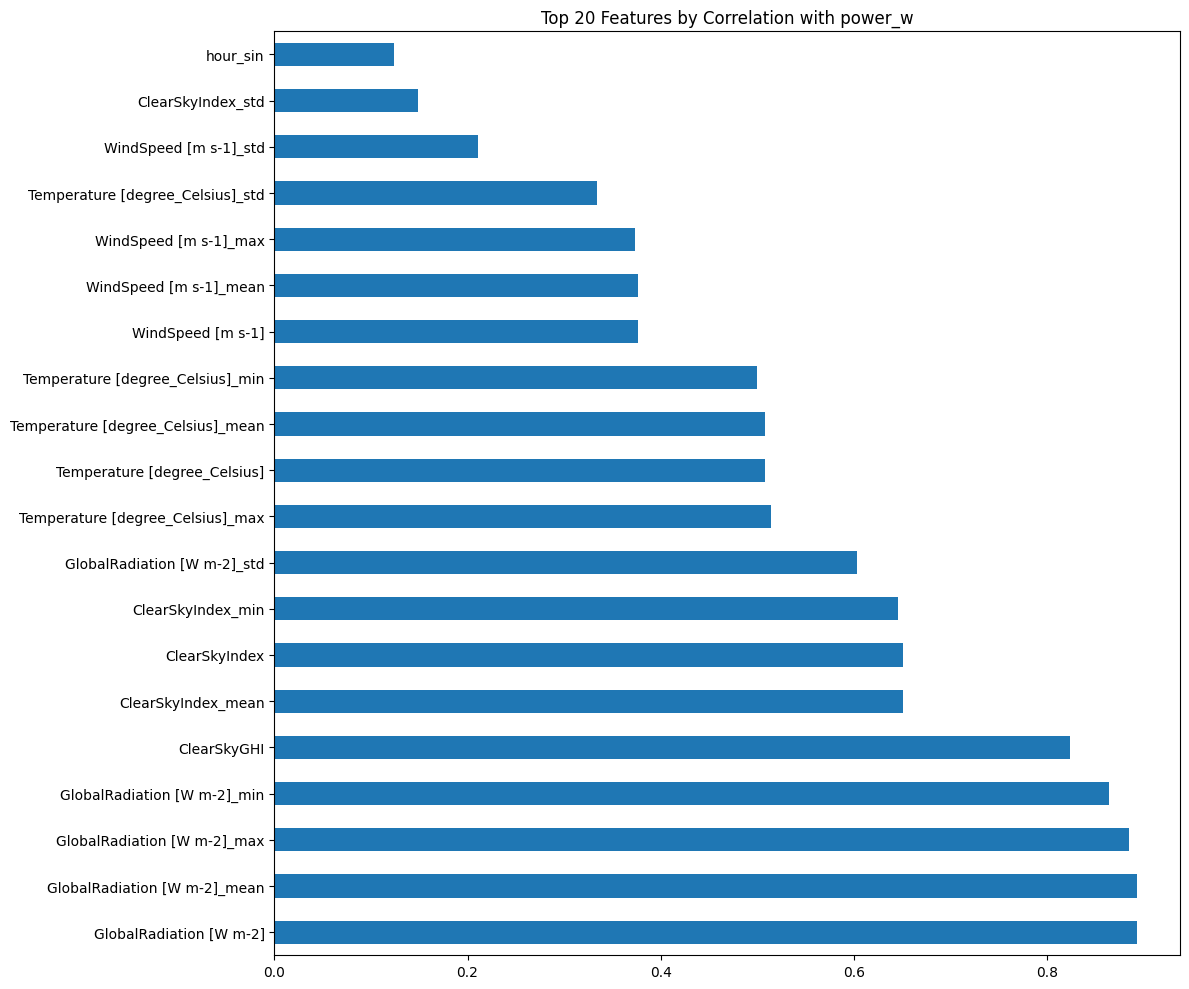


Aggregated features in top 10: 7 out of 10


In [15]:
# Calculate correlations with power_w
correlation = df_combined.corr()['power_w'].sort_values(ascending=False)
correlation = correlation.drop('power_w')  # Remove self-correlation

print("Top 10 features by correlation with power_w:")
print(correlation.head(10))

print("\nBottom 5 features by correlation with power_w:")
print(correlation.tail(5))

# Plot top 20 correlations
plt.figure(figsize=(12, 10))
top_n = 20
correlation_top = correlation.head(top_n)
correlation_top.plot(kind='barh')
plt.title(f'Top {top_n} Features by Correlation with power_w')
plt.tight_layout()
plt.savefig('results/feature_analysis/top_correlations_with_aggregations.png')
plt.show()

# Calculate how many aggregated features are in the top 10
agg_in_top10 = sum(1 for feature in correlation.head(10).index if any(suffix in feature for suffix in ['_mean', '_max', '_min', '_std', '_sum']))
print(f"\nAggregated features in top 10: {agg_in_top10} out of 10")

### Feature Importance Analysis

Let's examine if the statistical aggregations provide additional predictive power beyond the base features:

In [16]:
# Compare base features vs aggregated features
# Group features by their base name
feature_groups = {}
for col in df_combined.columns:
    if col == 'power_w':
        continue
        
    # Extract base feature name
    if any(suffix in col for suffix in ['_mean', '_max', '_min', '_std', '_sum']):
        base_name = col.split('_')[0] + ' ' + ' '.join(col.split(' ')[1:-1])
        if base_name not in feature_groups:
            feature_groups[base_name] = []
        feature_groups[base_name].append(col)
    else:
        if col not in feature_groups:
            feature_groups[col] = []
        feature_groups[col].append(col)

# For each feature group, find the highest correlated feature
best_features = {}
for base, features in feature_groups.items():
    if len(features) > 0:
        correlations = correlation[features]
        best_feature = correlations.idxmax()
        best_corr = correlations.loc[best_feature]
        best_features[base] = (best_feature, best_corr)

# Sort by correlation magnitude
sorted_best = sorted(best_features.items(), key=lambda x: abs(x[1][1]), reverse=True)

print("Best feature for each base feature group:")
for base, (feature, corr) in sorted_best:
    is_agg = 'Yes' if any(suffix in feature for suffix in ['_mean', '_max', '_min', '_std', '_sum']) else 'No'
    print(f"{base:30} -> {feature:40} (corr: {corr:.3f}, aggregated: {is_agg})")

Best feature for each base feature group:
GlobalRadiation [W m-2]        -> GlobalRadiation [W m-2]                  (corr: 0.893, aggregated: No)
GlobalRadiation [W m-2] [W     -> GlobalRadiation [W m-2]_mean             (corr: 0.893, aggregated: Yes)
ClearSkyGHI                    -> ClearSkyGHI                              (corr: 0.823, aggregated: No)
ClearSkyIndex                  -> ClearSkyIndex                            (corr: 0.651, aggregated: No)
ClearSkyIndex                  -> ClearSkyIndex_mean                       (corr: 0.651, aggregated: Yes)
hour_cos                       -> hour_cos                                 (corr: -0.634, aggregated: No)
isNight                        -> isNight                                  (corr: -0.631, aggregated: No)
Temperature [degree            -> Temperature [degree_Celsius]_max         (corr: 0.514, aggregated: Yes)
Temperature [degree_Celsius]   -> Temperature [degree_Celsius]             (corr: 0.508, aggregated: No)
WindSpee

### Visualizing the Value of Aggregated Features

Let's visualize how the aggregated features capture information that the base features miss:

In [ ]:
# Choose a high-correlation aggregated feature to visualize
agg_features_corr = [(f, c) for f, c in correlation.items() 
                     if any(suffix in f for suffix in ['_mean', '_max', '_min', '_std', '_sum'])]
top_agg_feature, top_agg_corr = sorted(agg_features_corr, key=lambda x: abs(x[1]), reverse=True)[0]

# Get the base feature name
base_feature = top_agg_feature.split('_')[0]
for part in top_agg_feature.split(' ')[1:]:
    if not any(suffix == part for suffix in ['mean', 'max', 'min', 'std', 'sum']):
        base_feature += ' ' + part

# Check if base feature exists in dataset
if base_feature in df_combined.columns:
    # Select a day with significant variation
    sample_day = df_combined[df_combined[top_agg_feature].std() > df_combined[top_agg_feature].std().mean()].index[0].date()
    day_data = df_combined[df_combined.index.date == sample_day]
    
    # Plot base feature vs aggregated feature vs power
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    color = 'tab:blue'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Feature Value', color=color)
    ax1.plot(day_data.index, day_data[base_feature], color=color, label=base_feature)
    ax1.plot(day_data.index, day_data[top_agg_feature], color='tab:orange', label=top_agg_feature)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    
    # Create a second y-axis for power
    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Power (W)', color=color)
    ax2.plot(day_data.index, day_data['power_w'], color=color, label='power_w')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')
    
    plt.title(f'Base vs Aggregated Feature: {base_feature} vs {top_agg_feature}\nDate: {sample_day}')
    plt.tight_layout()
    plt.savefig('results/feature_analysis/base_vs_aggregated_feature.png')
    plt.show()
    
    # Calculate correlation improvement
    base_corr = correlation.get(base_feature, 0)
    agg_corr = correlation.get(top_agg_feature, 0)
    print(f"Correlation improvement: {base_feature} ({base_corr:.3f}) vs {top_agg_feature} ({agg_corr:.3f})")
    print(f"Absolute improvement: {abs(agg_corr) - abs(base_corr):.3f}")

## 7. Saving the Enhanced Feature Set

Finally, let's save our enhanced feature set to a parquet file for use in LSTM modeling:

In [ ]:
# Save the final dataset
output_path = 'data/lstm_features_with_aggregations.parquet'
df_combined.to_parquet(output_path)
print(f"Dataset with hourly features and sub-hourly statistical aggregations saved to {output_path}")

# Summary statistics
print("\nSummary statistics of key features:")
selected_cols = ['power_w', 'GlobalRadiation [W m-2]', 'GlobalRadiation [W m-2]_max', 
                 'Temperature [degree_Celsius]', 'Temperature [degree_Celsius]_max',
                 'ClearSkyIndex', 'ClearSkyIndex_min']
summary_stats = df_combined[selected_cols].describe()
summary_stats.T[['mean', 'std', 'min', 'max']]

## 8. Conclusion and Next Steps

We've successfully created an enhanced feature set for LSTM-based PV power prediction by incorporating statistical aggregations from 10-minute data into an hourly feature set. This approach captures important sub-hourly variations that would be lost in simple hourly averages.

### Key Benefits of the Enhanced Feature Set

1. **Captures Sub-hourly Dynamics**: The statistical aggregations preserve information about short-term fluctuations in weather conditions that affect PV power generation.

2. **Maintains Hourly Timestamps**: By aggregating to hourly timestamps, we keep the dataset at a manageable size for LSTM modeling while preserving key information.

3. **Improved Feature Correlations**: Several aggregated features show higher correlation with power output than the base hourly features.

### Next Steps

1. Use this enhanced feature set in LSTM model training
2. Compare model performance with and without the aggregated features
3. Consider feature selection techniques to identify the most important subset of features
4. Explore different sequence lengths for the LSTM model to capture temporal dependencies

The final dataset `lstm_features_with_aggregations.parquet` is now ready for use in LSTM modeling.